In [69]:
#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

#Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Importing train, test split library
from sklearn.model_selection import train_test_split

#Metrices import
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

#Accuracy Check
from sklearn.model_selection import cross_val_score

#Importing custom packages
from sklearn.base import TransformerMixin

# Importing ML Model packages
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

#Import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the path
root_path = os.getcwd()
input_folder = "input"
intermediate_folder = "intermediate_files"
output_folder = "output"
input_file_name = "transactions.txt"
input_data_path = os.path.join(root_path, input_folder, input_file_name)

I have written some general classes and function for using into the future code. Some of the functions and class i coded later in the course so that the reader understands why and where it is used. In my general habbit i keep the caller functions seperate in utility folder and everything structured but for thorough explaination of my approach I used this jupyter notebook to explain my methodology.

In [3]:
# Imputing the remaining missing variables
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """
        Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        """

    def fit(self, A, b=None):

        self.fill = pd.Series(
            [
                A[c].value_counts().index[0]
                if A[c].dtype == np.dtype("O")
                else A[c].mean()
                for c in A
            ],
            index=A.columns,
        )

        return self

    def transform(self, A, b=None):
        return A.fillna(self.fill)
    
# Funtion to check the missing value count and percentage   
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data

def onehotdataframe(data, cat_cols):
    """
    Creates dummy features for categorical data.
    """
    for c in cat_cols:
        one_hot_col = pd.get_dummies(data[c])
        one_hot_col.columns = [str(col) + "_" + c for col in one_hot_col.columns]
        data = data.drop(c, axis=1)

        # Merging one hot encoded features with our dataset 'data'
        data = pd.concat([data, one_hot_col], axis=1)

    return data

# Creating a funtion to print model performance report on validation and test
def gen_class_report(model, model_name, X_val, y_val, X_test, y_test, val_skip):
    """
    Build a classication model performance report.
    val_skip = True implies skipping performance check on validation and performing check only on test.
    val_skip = False implies checking performance on both validation and test set
    """
    if val_skip == False:
        y_pred_val = model.predict(X_val)
        print(
            "Classification Report for {} model on validation set\n".format(model_name)
        )
        print(classification_report(y_val, y_pred_val))
        print(
            "\n accuracy: {} & roc_auc_score: {} \n".format(
                accuracy_score(y_val, y_pred_val), roc_auc_score(y_val, y_pred_val)
            )
        )
        cm_val = confusion_matrix(y_val, y_pred_val)

        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & roc_auc_score: {} \n".format(
                accuracy_score(y_test, y_pred_test), roc_auc_score(y_test, y_pred_test)
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return cm_val, cm_test
    else:
        print(
            "Classification Report for {} model on hold out test set\n".format(
                model_name
            )
        )
        y_pred_test = model.predict(X_test)
        print(classification_report(y_test, y_pred_test))
        print(
            "\n accuracy: {} & roc_auc_score: {} \n".format(
                accuracy_score(y_test, y_pred_test), roc_auc_score(y_test, y_pred_test)
            )
        )
        cm_test = confusion_matrix(y_test, y_pred_test)
        print("Confusion matrix on test set : \n")
        sns.heatmap(cm_test, annot=True, fmt="d", cbar=False)
        return "", cm_test
    
def get_feat_imp_plot(model, X):
    """
    input::model - A fitted trained model to plot the feature importance plot
    """
    # X and y were the full training data before splitting the data further in validation. Refer above
    features = list(X.columns)
    try:
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)

        plt.figure(figsize=(15, 20))
        plt.title("Feature Importances")
        plt.barh(range(len(indices)), importances[indices], color="b", align="center")
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Relative Importance")
        plt.show()
        return indices, importances
    except Exception as error:
        print('Model Doesnt Support feature importance calculations :' + repr(error))

#  Load + Data cleaning

In [4]:
# Import the data
tdata = pd.read_json(input_data_path, lines=True)

print(tdata.dtypes)
print("\n Below is the shape of the data: \n", tdata.shape)

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

###### Takeaway:
Account number, Customer Id are clearly the unique identifier of the transaction data which is in int format. Converting this into str so that we can get accurate statistics of this.

In [5]:
# Lets look at the data quickly
tdata.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


###### Takeaway:

The data is a daily level customer credit card transaction data with details along its transaction amount, merchant name, balance details and whether the transaction is fraud or not.

### Quick missing value check

In [6]:
# Converting blank spaces to null to capture the duplicates from our data
tdata.replace(r"^\s*$", np.nan, regex=True, inplace=True)
missing_val_check(tdata)

,Total,Percent(%)
recurringAuthInd,786363,100.000000
posOnPremises,786363,100.000000
merchantZip,786363,100.000000
merchantState,786363,100.000000
merchantCity,786363,100.000000
echoBuffer,786363,100.000000
acqCountry,4562,0.580139
posEntryMode,4054,0.515538
merchantCountryCode,724,0.092069
transactionType,698,0.088763


###### Takeaway:

1. Clearly the data is not clean in terms of missing value check
2. We can directly eliminate the variables with 100% data missing i.e. recurringAuthInd, posOnPremises, merchantZip, merchantState, merchantCity, echoBuffer.
3. Also we need to keep an eye over acqCountry, posEntryMode, merchantCountryCode, transactionType & posConditionCode which contains some missing value which needs check

In [7]:
# Dropping varibles based on the above takeaways:
misscols = [
    "recurringAuthInd",
    "posOnPremises",
    "merchantZip",
    "merchantState",
    "merchantCity",
    "echoBuffer",
]
tdata.drop(misscols, axis=1, inplace=True)

### Data Description

In [8]:
# Printing shape as asked in question
print("Shape of the data \n", tdata.shape)

# Converting identifiers of customers to str for better analysis of data
tdata["accountNumber"] = tdata["accountNumber"].astype("str")
tdata["customerId"] = tdata["customerId"].astype("str")

# Continous variable stats
display(tdata.describe())

Shape of the data 
 (786363, 23)


,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


###### Takeaway:

1. Clearly transaction number and customer id can be considered as categorical feature before we start building our model as these are assumed to be the unique identity to a transaction.

2. On first look creditLimit column, it looks like this variable tend to posses outliers on both below the lower bound (as min value is some where equal to 250 and the Q1 value is 5000) as well as the outliers are expected to be over the upper bound (as max value is 50000 while the median is 7500 and Q3 val is 7500). Hence we need to look at the box plots and understand if there are potential outliers. Basically box plot will check if any value is < Q1-1.5*IQR or > Q2 + 1.5*IQR respectively

3. Transction amount also looks like a right skewed data with potential outliers. Some other variable like transaction type, merchant name etc might affect this lets deep dive in this during EDA

3. Similary the availableMoney variables seems to posses potential outliers. Hence we need to check this as well. Additionally one more interest thing we can notice is that availableMoney contains negetive value. With an assumption og negetive value implies that the CC issuing company owes that amount to the customer. Hence we need to be careful while treating this variable.

4. cardCVV and enteredCVV can also be treated as categorical features however before we do that we need to check in which cases the two are different which can be a import feature for our model in predicting fraud later.

5. currentBalance also tend to contains outliers looking at the statistics of the data

##### Note: 

CreditLimit, availableMoney, currentBalance can contain outlier as some customer might use credit cards to extremes and some could use it on average basis and other might use it for bare minimum expenses. Hence we need to carefully treat them.

In [9]:
# Categorical/Ordinal variables statistics
tdata.describe(include=["O"])

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType
count,786363,786363,786363,786363,781801,785639,782309,785954,786363,786363,786363,786363,785665
unique,5000,5000,776637,2490,4,4,5,3,19,165,1820,2184,3
top,380680241,380680241,2016-12-25T14:04:15,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,PURCHASE
freq,32850,32850,4,25613,774709,778511,315035,628787,202156,5103,33623,3819,745193


###### Takeaway:

1. There are total 5000 unique customers with 5000 unique account hence there is no duplicacy in terms of one customer holdong multiple accounts which could be some source of fradulent activity.
2. By looking at the categorical/ordinal nothing looks off in first instance, Need to deep dive further with visuals and modelling inferences to take calls
3. Also looking at accountNumber and customerID stats it looks like the two columns are exactly duplicate.Lets check and remove one of them.

In [10]:
# Creating a check column
tdata["cust_acc_check"] = np.where(tdata["accountNumber"] != tdata["customerId"], 1, 0)
print(
    "Total count with accountNumber not equal to customerID is {}\n".format(
        tdata["cust_acc_check"].sum()
    )
)

if tdata["cust_acc_check"].sum() == 0:
    tdata.drop(["accountNumber", "cust_acc_check"], axis=1, inplace=True)
    print(
        "Both records duplicate hence can remove accountNumber variable from the data \n"
    )
else:
    tdata.drop(["cust_acc_check"], axis=1, inplace=True)
    print(
        "Both records are not duplicate hence can't remove accountNumber from the data\n"
    )
    
print(
    "The date range of the transaction for the given data lies between {} and {} \n".format(
        tdata["transactionDateTime"].min(), tdata["transactionDateTime"].max()
    )
)

# Also lets structure our categorical data
str_cols = ["merchantCategoryCode", "transactionType", "merchantName"]
tdata[str_cols] = tdata[str_cols].apply(lambda x: x.str.strip())
tdata[str_cols] = tdata[str_cols].apply(lambda x: x.str.upper())

# Cleaning Merchant category
tdata["merchantCategoryCode"] = tdata["merchantCategoryCode"].replace(
    "/", "_OR_", regex=True
)

# Save the cleaned data
tdata.to_csv(os.path.join(root_path,intermediate_folder, "cleaned_trans_data.csv"), index = False)

Total count with accountNumber not equal to customerID is 0

Both records duplicate hence can remove accountNumber variable from the data 

The date range of the transaction for the given data lies between 2016-01-01T00:01:02 and 2016-12-30T23:59:45 



# EDA - Focussing transaction Amount

<AxesSubplot:xlabel='transactionAmount', ylabel='Density'>

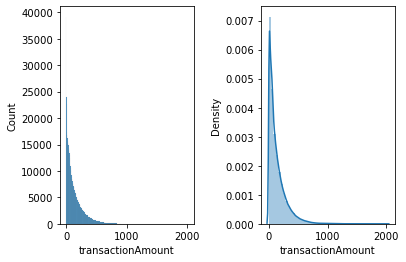

In [11]:
# Lets plot the histogram, density plotfor the transaction amount variable as asked:
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(1, 2, 1)
sns.histplot(tdata["transactionAmount"])
ax = fig.add_subplot(1, 2, 2)
sns.distplot(tdata["transactionAmount"])

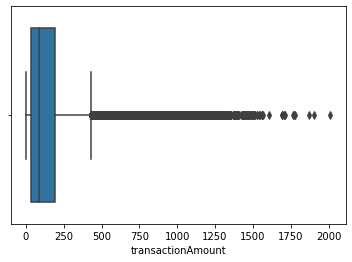

In [12]:
# Lets plot the box plot for transaction amount
sns.boxplot(tdata["transactionAmount"])
plt.show()

###### Takeaway:

1. As expected transaction amount is a right skewed data with outliers. Generally people might tend to spend less over credit card with some expections. This calls to two facts i.e. either people might purchase any expensive item or there might be a possible chance of fradulent transaction. Hence this can be an import factor in helping model to some extent.
2. Lets see relation of other features with transaction amount to see if anything make sense

Text(0.5, 0, "['US', 'CAN', nan, 'PR', 'MEX']")

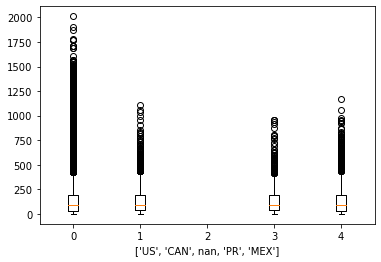

In [13]:
# Lets check the split of transaction amount by merchant country code
# Plotting the split of transaction amount by country code
fig = plt.figure()
ax = plt.subplot(111)
merchant_lst = list(tdata["merchantCountryCode"].unique())
for i in range(len(tdata["merchantCountryCode"].unique())):
    ax.boxplot(
        tdata[tdata["merchantCountryCode"] == merchant_lst[i]]["transactionAmount"],
        positions=[i],
    )
ax.set_xlabel(merchant_lst)

{0: 'RIDESHARE', 1: 'ENTERTAINMENT', 2: 'MOBILEAPPS', 3: 'FASTFOOD', 4: 'FOOD_DELIVERY', 5: 'AUTO', 6: 'ONLINE_RETAIL', 7: 'GYM', 8: 'HEALTH', 9: 'PERSONAL CARE', 10: 'FOOD', 11: 'FUEL', 12: 'ONLINE_SUBSCRIPTIONS', 13: 'ONLINE_GIFTS', 14: 'HOTELS', 15: 'AIRLINE', 16: 'FURNITURE', 17: 'SUBSCRIPTIONS', 18: 'CABLE_OR_PHONE'}


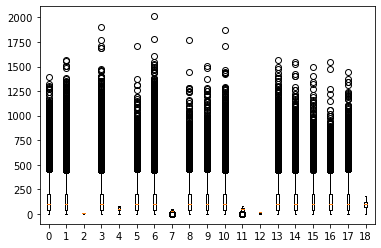

In [14]:
# Plotting the split of transaction amount by merchant category code
fig = plt.figure()
ax = plt.subplot(111)
idx_dict = {}
merchant_lst = list(tdata["merchantCategoryCode"].unique())
for i in range(len(tdata["merchantCategoryCode"].unique())):
    ax.boxplot(
        tdata[tdata["merchantCategoryCode"] == merchant_lst[i]]["transactionAmount"],
        positions=[i],
    )
    idx_dict[i] = merchant_lst[i]
print(idx_dict)

##### Takeaway:

1. Transaction amount for Merchant codes in all countries have roughly similar median however transaction in the US have higher upper bounds.

2. Similarly on an average expenditure over most of the categories of merchant have similart Q1-Q3 of spending range with approximately common medians, however people to spend a lot over online_retail followed by fastfood. On the lower sides transaction are on mobileapps, food_delivery, gym, fuel, online_subscription and cable/phone. Hence these merchent category of transaction are assumed to be on lower risk to be fradulent as also we dont see any outliers within them as well. Hence might be a pretty strong predictor for our model.

Text(0, 0.5, 'Merchent')

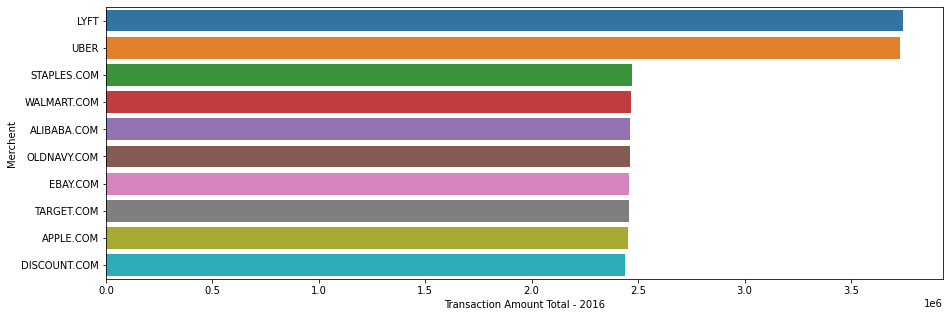

In [15]:
# Lets look at the top transactions by individual merchant:
plt.figure(figsize=(15, 5))
top10_merch = tdata.groupby(["merchantName"])["transactionAmount"].sum().reset_index()
top10_merch = top10_merch.sort_values(["transactionAmount"], ascending=False)
top10_merch = top10_merch.head(10)
sns.barplot(
    x=top10_merch["transactionAmount"], y=top10_merch["merchantName"].values, orient="h"
)
plt.xlabel("Transaction Amount Total - 2016")
plt.ylabel("Merchent")

##### Takeaways:

1. People tend to spend a lot in total over lyft, uber and the online platforms like staples, walmart and amazon using the card.
2. But we need to look over the average transaction as well to build any hypothesis which can lead to fradulent transactions.

Text(0, 0.5, 'Merchent')

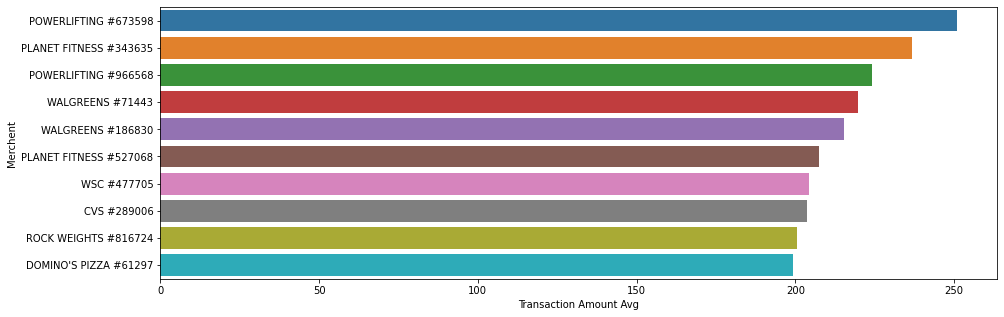

In [16]:
# Lets look at the top transactions by individual merchant:
plt.figure(figsize=(15, 5))
top10_merchavg = (
    tdata.groupby(["merchantName"])["transactionAmount"].mean().reset_index()
)
top10_merchavg = top10_merchavg.sort_values(["transactionAmount"], ascending=False)
top10_merchavg = top10_merchavg.head(10)
sns.barplot(
    x=top10_merchavg["transactionAmount"],
    y=top10_merchavg["merchantName"].values,
    orient="h",
)
plt.xlabel("Transaction Amount Avg")
plt.ylabel("Merchent")

##### Takeaways:

On an average people tend to spend more on powerlifting, planetfitness, WSC, CVS hence these might be more prone to fradulent activities, which we need to further check.

Text(0.5, 0.98, 'Density plots')

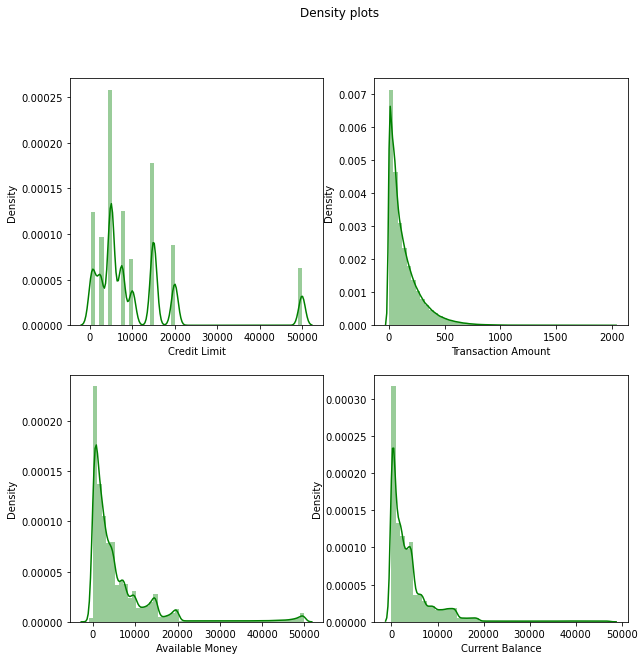

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cont_cols = ["creditLimit", "transactionAmount", "availableMoney", "currentBalance"]
cols_corrected = [
    "Credit Limit",
    "Transaction Amount",
    "Available Money",
    "Current Balance",
]
var_idx = 0

for i in range(2):
    for j in range(2):
        sns.distplot(tdata[cont_cols[var_idx]], ax=ax[i][j], color="green")
        ax[i][j].set_xlabel(cols_corrected[var_idx])
        var_idx += 1

fig.suptitle("Density plots")

Text(0.5, 0.98, 'Density plots')

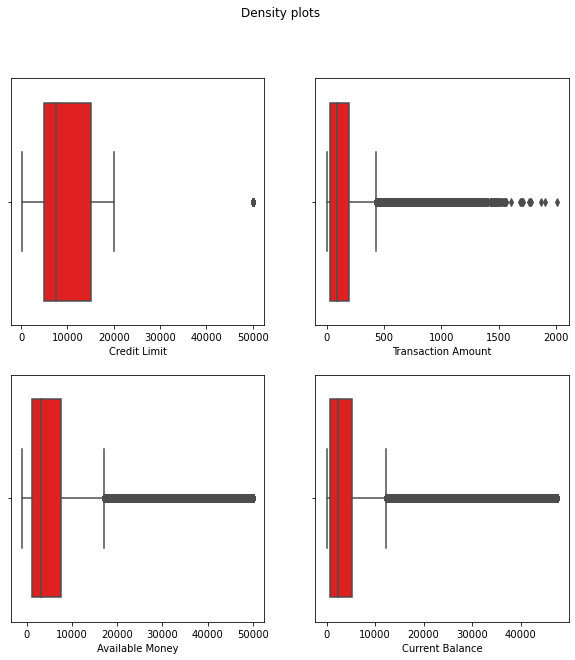

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cont_cols = ["creditLimit", "transactionAmount", "availableMoney", "currentBalance"]
cols_corrected = [
    "Credit Limit",
    "Transaction Amount",
    "Available Money",
    "Current Balance",
]
var_idx = 0

for i in range(2):
    for j in range(2):
        sns.boxplot(tdata[cont_cols[var_idx]], ax=ax[i][j], color="red")
        ax[i][j].set_xlabel(cols_corrected[var_idx])
        var_idx += 1

fig.suptitle("Density plots")

##### Takeaways:
1. Noticingly mostly people tend to spend around 125 dollars during one transaction which seems normal. However there is no transaction worth more than 2000 dollars with a credit limit of few customers being around 50000 dollars.
2. As the spend is low the available money and credit balance median looks fine.

<AxesSubplot:>

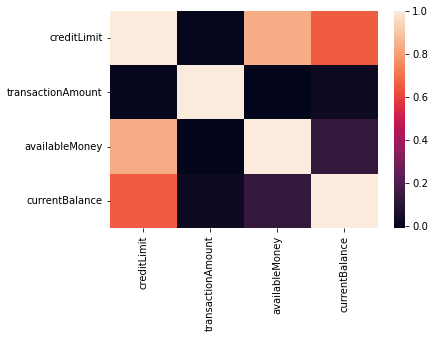

In [19]:
# Lets plot correlation heatmap
corr = tdata[cont_cols].corr()
sns.heatmap(corr)

##### Takeaways:

1. Credit limit mostly centered towards 10000 dollars with few outliers in close proximity to 50000 dollars which make sense for current balance/available exceeding till 40000 dollars
2. Interestingly the correlation seems a bit off when comparing transaction amount with available money, current balance and credit limit.
3. Current balance/ available money has high correlation with credit limit which is quite obvious.

Text(0, 0.5, 'Transaction Amount')

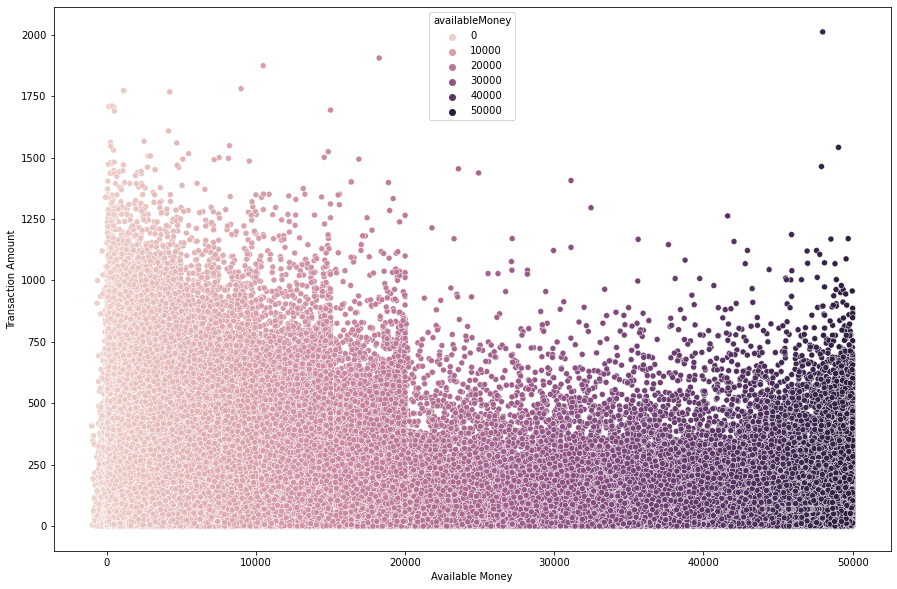

In [20]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=tdata, x="availableMoney", y="transactionAmount", hue="availableMoney"
)
plt.xlabel("Available Money")
plt.ylabel("Transaction Amount")

##### Takeaways:

1. There is an interesting trend towards people having lesser available money to spend. There is a lot of values where the transaction amount is greater than the available money which can be potential red flags to note. Hence we need to create a feature later to give some inputs to model. 

2. On the other hand people having potentially more available money tend spend lower in comparison to lower ones. Hence to capture fraud in such accounts can prove to be a lil difficult for the model.

<AxesSubplot:xlabel='creditLimit', ylabel='transactionAmount'>

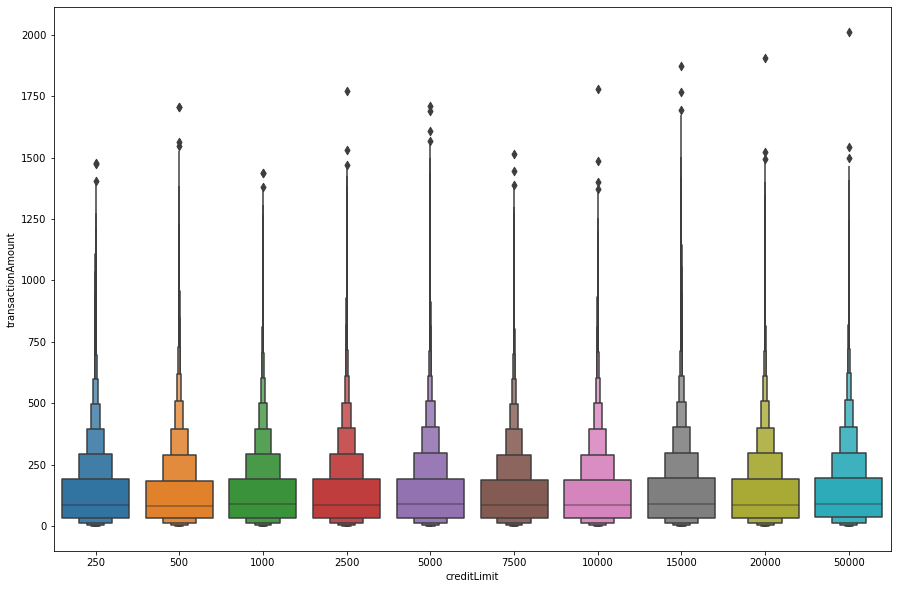

In [21]:
plt.figure(figsize=(15, 10))
sns.boxenplot(data=tdata, x="creditLimit", y="transactionAmount", k_depth="trustworthy")

##### Takeaways:

1. If we look at the credit limits <1000 dollars we can surprisingly observe that the transaction amount is way above the credit limits in some of the cases, which can be a potential red flag and might be an fradulent activity.
2. Customers having credit limits greater than 2000 dollars tend to spend within the limits and no extreme outliers are observed beyond the credit limits. Hence this variable can be an important estimate.

# Data Wrangling duplicate Transaction

In the question it is asked to get the reversal records. In the data reversal records are already marked hence we will skip this (In the interest of time I have). But the logic can be implemented.

### Checking reversed transactions

In [22]:
# Converting string dates to datetime type
tdata[["dateOfLastAddressChange", "accountOpenDate"]] = tdata[
    ["dateOfLastAddressChange", "accountOpenDate"]
].apply(pd.to_datetime)

# Extracting date from the data - shiftup
tdata["transactionDate"] = pd.to_datetime(tdata["transactionDateTime"]).dt.date

rev_data = tdata[tdata["transactionType"] == "REVERSAL"].copy()
print(
    "Total reversed transaction are {} with the dollar amount of ${}".format(
        rev_data.shape[0], rev_data["transactionAmount"].sum()
    )
)

Total reversed transaction are 20303 with the dollar amount of $2821792.5


### Checking multi swipe transactions

In [23]:
# Creating a key joining customerid, transaction datetime, transaction amount & merchant name
cols = [
    "customerId",
    "merchantName",
    "transactionDateTime",
    "transactionAmount",
    "transactionType",
]
tdata["transkey"] = tdata[cols].apply(
    lambda row: "_".join(row.values.astype(str)), axis=1
)

# Creating a key joining customerid, transaction date, transaction amount & merchant name
# Note this might not be a unique identifier of the transaction
colswdt = [
    "customerId",
    "merchantName",
    "transactionDate",
    "transactionAmount",
    "transactionType",
]
tdata["transkeybdate"] = tdata[colswdt].apply(
    lambda row: "_".join(row.values.astype(str)), axis=1
)

# lets flag the transaction happened on same day multiple time by transkeybdate
tdata["flag_multiswipe"] = (
    tdata["transkeybdate"].duplicated(keep=False).map({True: 1, False: 0})
)
mswipe_trans = tdata[tdata["flag_multiswipe"] == 1].copy()

# Now lets select the first transaction form the transkeybdate that needs to be excluded from the calculations
reg_trans = (
    tdata[tdata["flag_multiswipe"] == 1]
    .sort_values("transkey")
    .drop_duplicates(["transkeybdate"], keep="first")
)
reg_trans_key = list(reg_trans["transkey"].unique())

# Removing regular entries in the data to get the total multiswipe transaction count and amount value
mswipe_trans = mswipe_trans[~mswipe_trans["transkey"].isin(reg_trans_key)]
mswipe_trans_key = list(mswipe_trans["transkey"].unique())

tdata.drop(["flag_multiswipe"], axis=1, inplace=True)
print(
    "Total multiswipe transaction are {} with the dollar amount of ${}".format(
        mswipe_trans.shape[0], mswipe_trans["transactionAmount"].sum()
    )
)

# Lets flag the multiswipe transaction back to the transaction data that we created.
tdata["is_multiswipe"] = np.where(tdata["transkey"].isin(mswipe_trans_key), "Y", "N")

Total multiswipe transaction are 7832 with the dollar amount of $1103230.78


Overall Percent Fraud Transaction Distribution %:
False    98.420958
True      1.579042
Name: isFraud, dtype: float64


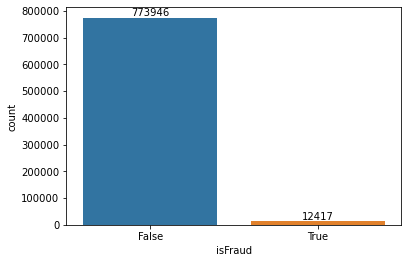

In [24]:
# Drawing a count plot of dependent variable to check the biasness of prediction in data present
ax = sns.countplot(
    x=tdata["isFraud"], order=tdata["isFraud"].value_counts(ascending=False).index
)
abs_values = tdata["isFraud"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

print("Overall Percent Fraud Transaction Distribution %:")
print(tdata["isFraud"].value_counts(normalize=True) * 100)

False    7701
True      131
Name: isFraud, dtype: int64

By Percentage %:
False    98.327375
True      1.672625
Name: isFraud, dtype: float64


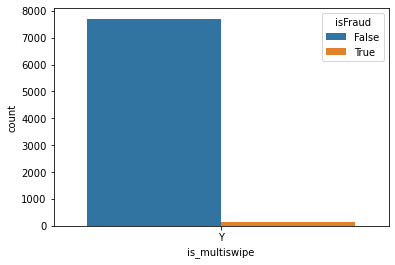

In [25]:
sns.countplot(
    x="is_multiswipe", hue="isFraud", data=tdata[tdata["is_multiswipe"] == "Y"]
)
print(tdata[tdata["is_multiswipe"] == "Y"]["isFraud"].value_counts())

print("\nBy Percentage %:")
print(
    tdata[tdata["is_multiswipe"] == "Y"]["isFraud"].value_counts(normalize=True) * 100
)

False    19966
True       337
Name: isFraud, dtype: int64

By Percentage %:
False    98.340147
True      1.659853
Name: isFraud, dtype: float64


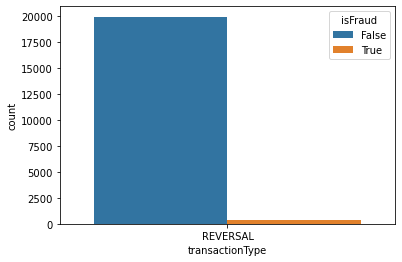

In [26]:
sns.countplot(
    x="transactionType",
    hue="isFraud",
    data=tdata[tdata["transactionType"] == "REVERSAL"],
)
print(tdata[tdata["transactionType"] == "REVERSAL"]["isFraud"].value_counts())

print("\nBy Percentage %:")
print(
    tdata[tdata["transactionType"] == "REVERSAL"]["isFraud"].value_counts(
        normalize=True
    )
    * 100
)

##### Takeaways:

Looking at the reversal and multiswipe transaction it depicts that such transactions have more fraudulent percentage when compared to the overall data. Although the percentage is still low but mathematically the percentage is higher than the overall fradulent transaction percentage. This means some cases of multiswipe and reversal are true but might be some fradulent activities happening over the owner's credit card.

# Modelling for fraudulent data

## Feature Engineering & Further Deep dive

#### Before we start the modelling part lets see some more relationship of our target variable with the other variables. Lets first check intuitively how we can check on an superlative level, the reason for fraud transaction.

1. Lets first create a flag which will check if correct CVV and entered CVV are equal and then check the distribution of this flag with the target if this make sense - featEng
2. Will create total time the use changed the address at that reference time which might be an useful feature for the model

For matching CVVs fraud transaction distribution: 

False    767134
True      12214
Name: isFraud, dtype: int64

By Percentage %:
False    98.432793
True      1.567207
Name: isFraud, dtype: float64

For non matching CVVs fraud transaction distribution: 

False    6812
True      203
Name: isFraud, dtype: int64

By Percentage %:
False    97.106201
True      2.893799
Name: isFraud, dtype: float64


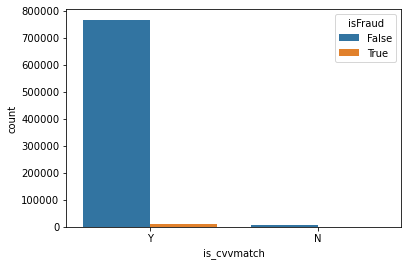

In [27]:
# 1. Creating mismatch CVV flag
tdata["is_cvvmatch"] = tdata["cardCVV"] == tdata["enteredCVV"]
tdata["is_cvvmatch"] = tdata["is_cvvmatch"].map({True: "Y", False: "N"})
ax = sns.countplot(data=tdata, x="is_cvvmatch", hue="isFraud")

print("For matching CVVs fraud transaction distribution: \n")
print(tdata[tdata["is_cvvmatch"] == "Y"]["isFraud"].value_counts())
print("\nBy Percentage %:")
print(tdata[tdata["is_cvvmatch"] == "Y"]["isFraud"].value_counts(normalize=True) * 100)

print("\nFor non matching CVVs fraud transaction distribution: \n")
print(tdata[tdata["is_cvvmatch"] == "N"]["isFraud"].value_counts())
print("\nBy Percentage %:")
print(tdata[tdata["is_cvvmatch"] == "N"]["isFraud"].value_counts(normalize=True) * 100)

##### Takeaway:

1. As per my assumption there should have been significantly high fradulent percentages when CVV is entered incorrectly but here altough the percentage is >2.5% which is higher than overall fraudulent transaction distribution, the number is not too high. This implies that in many transaction the user might be incorrectly entering their CVVs maybe in case of hurry or any other reason. 
2. However this feature can prove to be important to detect fraud with combination of feature set

Text(0, 0.5, 'Merchent')

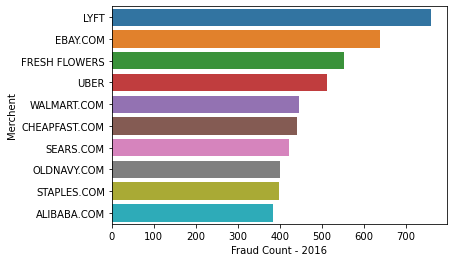

In [28]:
# Lets check the merchents with most fraud transaction
fraud_dt = tdata[tdata["isFraud"] == True].copy()

# Selecting top10 fraud merchents
top10_fraudmerch = fraud_dt.groupby(["merchantName"])["isFraud"].count().reset_index()
top10_fraudmerch = top10_fraudmerch.sort_values(["isFraud"], ascending=False)
top10_fraudmerch = top10_fraudmerch.head(10)

sns.barplot(
    x=top10_fraudmerch["isFraud"], y=top10_fraudmerch["merchantName"].values, orient="h"
)
plt.xlabel("Fraud Count - 2016")
plt.ylabel("Merchent")

Text(0, 0.5, 'Merchent Category')

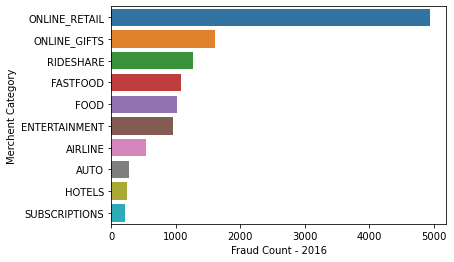

In [29]:
# Similar checks for merchant category
top10_fraudmerch = (
    fraud_dt.groupby(["merchantCategoryCode"])["isFraud"].count().reset_index()
)
top10_fraudmerch = top10_fraudmerch.sort_values(["isFraud"], ascending=False)
top10_fraudmerch = top10_fraudmerch.head(10)

sns.barplot(
    x=top10_fraudmerch["isFraud"],
    y=top10_fraudmerch["merchantCategoryCode"].values,
    orient="h",
)
plt.xlabel("Fraud Count - 2016")
plt.ylabel("Merchent Category")

##### Takeaway:

1. Most of the fraudulent transaction happens over lyft, ebay, freshflowers followed by uber, walmart i.e. online retail, gifts and rideshares. This might makes sense for lyft, ebay, fresh flower since the business model is consumer-consumer so its easy to encash the money. Then other online website also have risk of frauds, surprisingly uber, walmart are one of them. Hence this feature might be an important predictor.

2. One point noted here is that the merchant category is bucketed version of merchant name which shows very similar results and observations which can be easy for model to use reducing noise that can be generated through sparesity of this variable. Hence we can drop this and take the categories.

Text(0, 0.5, 'Customer_ID')

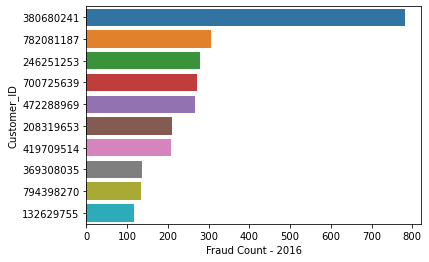

In [30]:
# Lets check the customers with most fraud transactions

top10_fraudcust = fraud_dt.groupby(["customerId"])["isFraud"].count().reset_index()
top10_fraudcust = top10_fraudcust.sort_values(["isFraud"], ascending=False)
top10_fraudcust = top10_fraudcust.head(10)
top10_fraudcustlst = list(top10_fraudcust["customerId"].unique())

sns.barplot(
    x=top10_fraudcust["isFraud"], y=top10_fraudcust["customerId"].values, orient="h"
)
plt.xlabel("Fraud Count - 2016")
plt.ylabel("Customer_ID")

##### Takeaway:

380680241 - This customer has a reasonably large number of fraud transactions as reported in the data followed by some others.

Lets also look at on which merchent these customers are prone to have frauds !

Text(0.5, 1.0, 'Top 10 Fraud customers ids likely merchent target')

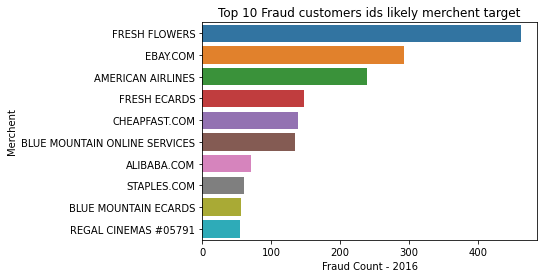

In [31]:
top10_fraudcustmerch = (
    fraud_dt[fraud_dt["customerId"].isin(top10_fraudcustlst)]
    .groupby(["merchantName"])["isFraud"]
    .count()
    .reset_index()
)
top10_fraudcustmerch = top10_fraudcustmerch.sort_values(["isFraud"], ascending=False)
top10_fraudcustmerch = top10_fraudcustmerch.head(10)

sns.barplot(
    x=top10_fraudcustmerch["isFraud"],
    y=top10_fraudcustmerch["merchantName"].values,
    orient="h",
)
plt.xlabel("Fraud Count - 2016")
plt.ylabel("Merchent")
plt.title("Top 10 Fraud customers ids likely merchent target")

Text(0.5, 1.0, 'Top 10 Fraud customers ids likely merchent target')

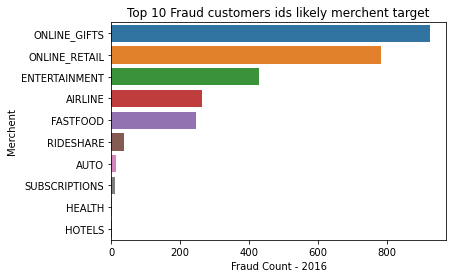

In [32]:
top10_fraudcustmerch = (
    fraud_dt[fraud_dt["customerId"].isin(top10_fraudcustlst)]
    .groupby(["merchantCategoryCode"])["isFraud"]
    .count()
    .reset_index()
)
top10_fraudcustmerch = top10_fraudcustmerch.sort_values(["isFraud"], ascending=False)
top10_fraudcustmerch = top10_fraudcustmerch.head(10)

sns.barplot(
    x=top10_fraudcustmerch["isFraud"],
    y=top10_fraudcustmerch["merchantCategoryCode"].values,
    orient="h",
)
plt.xlabel("Fraud Count - 2016")
plt.ylabel("Merchent")
plt.title("Top 10 Fraud customers ids likely merchent target")

##### Takeaway:

This looks pretty much according to the assumption that online_gifts & retail are easy way to encash fraud money hence expenditure is also observed in these categories

Text(0.5, 1.0, 'Transaction Amount Distribution of Non-Fraud transactions')

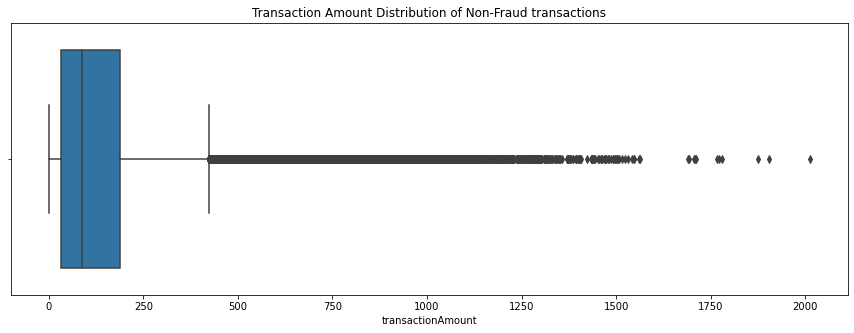

In [33]:
plt.figure(figsize=(15, 5))
sns.boxplot(tdata[tdata["isFraud"] == False]["transactionAmount"])
plt.title("Transaction Amount Distribution of Non-Fraud transactions")

<AxesSubplot:title={'center':'Transaction Amount Distribution of the top 10 fraudulent customers fraud transactions'}, xlabel='transactionAmount'>

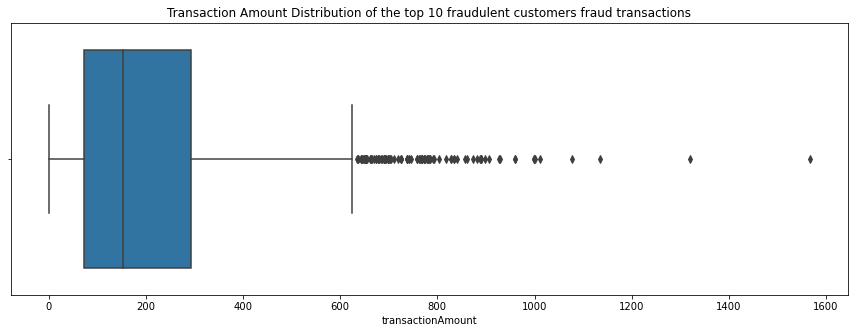

In [34]:
plt.figure(figsize=(15, 5))
plt.title(
    "Transaction Amount Distribution of the top 10 fraudulent customers fraud transactions"
)
sns.boxplot(
    fraud_dt[fraud_dt["customerId"].isin(top10_fraudcustlst)]["transactionAmount"]
)

##### Takeaway:

Clear we can compare the non fradulent transaction with the top 10 customer encountering maximum fraud we can clearly see the shift in median of the transaction amount and the shift in Q3 value of this data. This is quite expected as fraud transactions will tend to happen over a large sum of money and shift in the median and Q3 looks valid.

<AxesSubplot:xlabel='cardPresent', ylabel='count'>

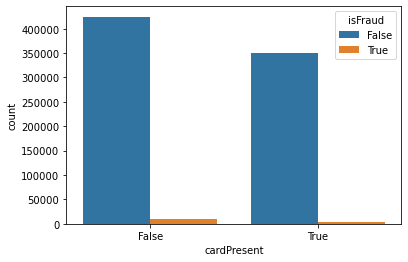

In [35]:
# Lets check the card present variable if this can provide any insights to our data
sns.countplot(x="cardPresent", hue="isFraud", data=tdata)

<AxesSubplot:xlabel='expirationDateKeyInMatch', ylabel='count'>

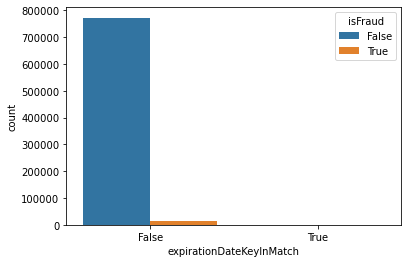

In [36]:
# Lets check the card present variable if this can provide any insights to our data
sns.countplot(x="expirationDateKeyInMatch", hue="isFraud", data=tdata)

##### Takeaway:
Yes this variable can prove to be imported since we can clearly see a significant jump in the fraud transaction when the card is not present.

For 01 posConditionCode fraud transaction distribution: 

False    618557
True      10230
Name: isFraud, dtype: int64

By Percentage %:
False    98.373058
True      1.626942
Name: isFraud, dtype: float64

For 08 posConditionCode fraud transaction distribution: 

False    147698
True       1936
Name: isFraud, dtype: int64

By Percentage %:
False    98.706176
True      1.293824
Name: isFraud, dtype: float64

For 99 posConditionCode fraud transaction distribution: 

False    7304
True      229
Name: isFraud, dtype: int64

By Percentage %:
False    96.960042
True      3.039958
Name: isFraud, dtype: float64


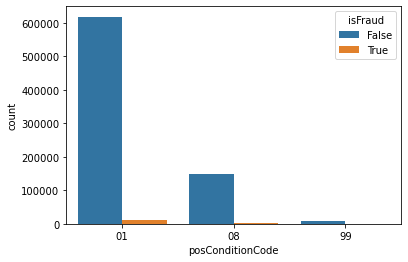

In [37]:
# Similarly lets check posEntryMode and posEntryCode if we can see any insight
sns.countplot(x="posConditionCode", hue="isFraud", data=tdata)

print("For 01 posConditionCode fraud transaction distribution: \n")
print(tdata[tdata["posConditionCode"] == "01"]["isFraud"].value_counts())
print("\nBy Percentage %:")
print(
    tdata[tdata["posConditionCode"] == "01"]["isFraud"].value_counts(normalize=True)
    * 100
)

print("\nFor 08 posConditionCode fraud transaction distribution: \n")
print(tdata[tdata["posConditionCode"] == "08"]["isFraud"].value_counts())
print("\nBy Percentage %:")
print(
    tdata[tdata["posConditionCode"] == "08"]["isFraud"].value_counts(normalize=True)
    * 100
)

print("\nFor 99 posConditionCode fraud transaction distribution: \n")
print(tdata[tdata["posConditionCode"] == "99"]["isFraud"].value_counts())
print("\nBy Percentage %:")
print(
    tdata[tdata["posConditionCode"] == "99"]["isFraud"].value_counts(normalize=True)
    * 100
)

##### Takeaway:

There might definately be some predictability power of this feature when we look at the percentage of fraud transaction variations from this variable


For 02 posEntryMode fraud transaction distribution: 

False    192513
True       3421
Name: isFraud, dtype: int64

By Percentage %:
False    98.254004
True      1.745996
Name: isFraud, dtype: float64

For 09 posEntryMode fraud transaction distribution: 

False    230822
True       5659
Name: isFraud, dtype: int64

By Percentage %:
False    97.606996
True      2.393004
Name: isFraud, dtype: float64

For 05 posEntryMode fraud transaction distribution: 

False    312579
True       2456
Name: isFraud, dtype: int64

By Percentage %:
False    99.220404
True      0.779596
Name: isFraud, dtype: float64

For 80 posEntryMode fraud transaction distribution: 

False    15043
True       240
Name: isFraud, dtype: int64

By Percentage %:
False    98.429628
True      1.570372
Name: isFraud, dtype: float64

For 90 posEntryMode fraud transaction distribution: 

False    19204
True       372
Name: isFraud, dtype: int64

By Percentage %:
False    98.099714
True      1.900286
Name: isFraud, dtype: float64

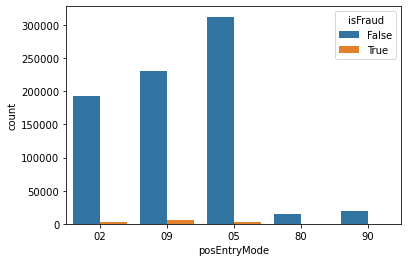

In [38]:
# Similarly lets check posEntryMode and posEntryCode if we can see any insight
sns.countplot(x="posEntryMode", hue="isFraud", data=tdata)
for pec in tdata["posEntryMode"].unique():
    if pec == "":
        pass
    else:
        print("\nFor {} posEntryMode fraud transaction distribution: \n".format(pec))
        print(tdata[tdata["posEntryMode"] == pec]["isFraud"].value_counts())
        print("\nBy Percentage %:")
        print(
            tdata[tdata["posEntryMode"] == pec]["isFraud"].value_counts(normalize=True)
            * 100
        )

##### Takeaway:

This feature also have some variability in prediction of fraud with entryMode '09' giving highest percentage of fraud transaction cases

Text(0.5, 1.0, 'Distribution of total address changes for fradulent transactions')

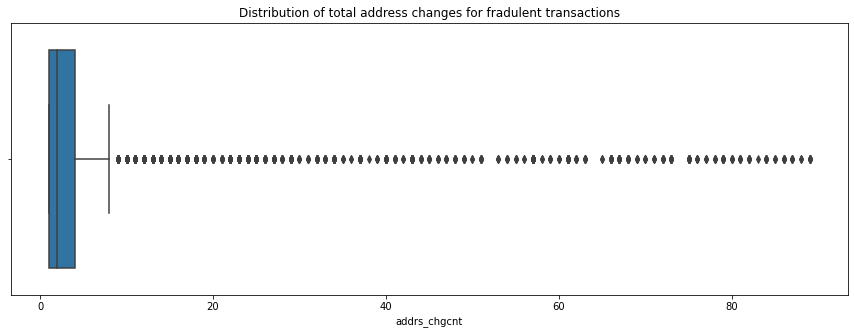

In [39]:
# Creating total times the customer changed address at the instance of the transaction
tdata["addrs_chgdiff"] = (
    tdata["dateOfLastAddressChange"] - tdata["accountOpenDate"]
).dt.days
tdata["addrs_chgcnt"] = tdata.groupby("customerId")["addrs_chgdiff"].rank("dense")
tdata.drop(["addrs_chgdiff"], axis=1, inplace=True)

# Plotting the address change count distribution for fradulent transactions
plt.figure(figsize=(15, 5))
sns.boxplot(tdata[tdata["isFraud"] == True]["addrs_chgcnt"])
plt.title("Distribution of total address changes for fradulent transactions")

##### Takeaway:

Customers with frequent address changes looks highly susceptible to fradulent activities

### Generating RFM Score

Performing RFM Analysis. I used this when I build my first fraud detection model at Abinbev. Sourced from geeks from geeks.

RFM stands for recency, frequency, monetary value. In business analytics, we often use this concept to divide customers into different segments, like high-value customers, medium value customers or low-value customers, and similarly many others

Recency: How recently has the customer made a transaction with us
Frequency: How frequent is the customer in ordering/buying some product from us
Monetary: How much does the customer spend on purchasing products from us.

-- Source - Geeks for Geeks

In [40]:
def rfm_df(tdata, cust_col, monetry_col):
    # Recency
    tdata_recency = tdata.groupby(by=cust_col, as_index=False)["transactionDate"].max()
    tdata_recency.columns = [cust_col, "LastPurchaseDate"]
    recent_date = tdata_recency["LastPurchaseDate"].max()
    tdata_recency["Recency"] = tdata_recency["LastPurchaseDate"].apply(
        lambda x: (recent_date - x).days
    )

    print("\n Recency numbers looks like this \n\n{}".format(tdata_recency.head(5)))

    # Frequency
    frequency_tdata = (
        tdata.drop_duplicates()
        .groupby(by=[cust_col], as_index=False)["transactionDate"]
        .count()
    )
    frequency_tdata.columns = [cust_col, "Frequency"]
    print(
        "\n\n Frequency numbers looks like this \n\n{} ".format(frequency_tdata.head(5))
    )

    # Monetry
    monetary_tdata = tdata.groupby(by=cust_col, as_index=False)[monetry_col].sum()
    monetary_tdata.columns = [cust_col, "Monetary"]
    monetary_tdata.head()
    print("Monetary numbers looks like this \n\n{}".format(monetary_tdata.head()))

    # Merging all three metric
    rf_tdata = tdata_recency.merge(frequency_tdata, on=cust_col)
    rfm_tdata = rf_tdata.merge(monetary_tdata, on=cust_col).drop(
        columns="LastPurchaseDate"
    )

    # Ranking the metrics
    rfm_tdata["R_rank"] = rfm_tdata["Recency"].rank(ascending=False)
    rfm_tdata["F_rank"] = rfm_tdata["Frequency"].rank(ascending=True)
    rfm_tdata["M_rank"] = rfm_tdata["Monetary"].rank(ascending=True)

    # normalizing the rank of the customers
    rfm_tdata["R_rank_norm"] = (rfm_tdata["R_rank"] / rfm_tdata["R_rank"].max()) * 100
    rfm_tdata["F_rank_norm"] = (rfm_tdata["F_rank"] / rfm_tdata["F_rank"].max()) * 100
    rfm_tdata["M_rank_norm"] = (rfm_tdata["F_rank"] / rfm_tdata["M_rank"].max()) * 100

    rfm_tdata.drop(columns=["R_rank", "F_rank", "M_rank"], inplace=True)

    # Creating RFM by applying formula
    rfm_tdata["RFM_Score"] = (
        0.15 * rfm_tdata["R_rank_norm"]
        + 0.28 * rfm_tdata["F_rank_norm"]
        + 0.57 * rfm_tdata["M_rank_norm"]
    )
    rfm_tdata["RFM_Score"] *= 0.05
    rfm_tdata = rfm_tdata.round(2)
    print("\n\n RFM Metric looks like this \n\n{} ".format(rfm_tdata.head(5)))

    # Segmenting the customers based upon score
    """
    Rating Customer based upon the RFM score:

    rfm score >4.5 : Top Customer

    4.5 > rfm score > 4 : High Value Customer

    4>rfm score >3 : Medium value customer

    3>rfm score>1.6 : Low-value customer

    rfm score<1.6 :Lost Customer
    """
    rfm_tdata["Customer_segment"] = np.where(
        rfm_tdata["RFM_Score"] > 4.5,
        "Top_Customers",
        (
            np.where(
                rfm_tdata["RFM_Score"] > 4,
                "High_value_Customer",
                (
                    np.where(
                        rfm_tdata["RFM_Score"] > 3,
                        "Medium_Value_Customer",
                        np.where(
                            rfm_tdata["RFM_Score"] > 1.6,
                            "Low_Value_Customers",
                            "Lost_Customers",
                        ),
                    )
                ),
            )
        ),
    )

    print(
        "\n\n RFM Segmentation looks like this \n\n{} ".format(
            rfm_tdata[["customerId", "RFM_Score", "Customer_segment"]].head(5)
        )
    )

    return rfm_tdata

In [41]:
rfm_tdata = rfm_df(tdata, cust_col="customerId", monetry_col="transactionAmount")


 Recency numbers looks like this 

  customerId LastPurchaseDate  Recency
0  100088067       2016-12-28        2
1  100108752       2016-12-16       14
2  100328049       2016-12-28        2
3  100663626       2016-12-29        1
4  100737756       2016-12-23        7


 Frequency numbers looks like this 

  customerId  Frequency
0  100088067         75
1  100108752         18
2  100328049        103
3  100663626         31
4  100737756        178 
Monetary numbers looks like this 

  customerId  Monetary
0  100088067   8028.34
1  100108752    997.95
2  100328049  11991.18
3  100663626   6422.27
4  100737756  30714.02


 RFM Metric looks like this 

  customerId  Recency  Frequency  Monetary  R_rank_norm  F_rank_norm  \
0  100088067        2         75   8028.34        65.79        62.25   
1  100108752       14         18    997.95        16.39        20.38   
2  100328049        2        103  11991.18        65.79        70.92   
3  100663626        1         31   6422.27        78.

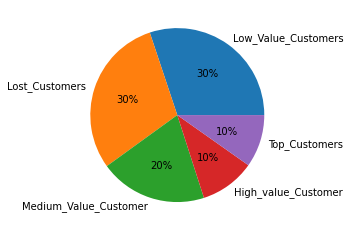

In [42]:
# Lets plot the customer segmentation split of customers
plt.pie(
    rfm_tdata.Customer_segment.value_counts(),
    labels=rfm_tdata.Customer_segment.value_counts().index,
    autopct="%.0f%%",
)
plt.show()

Lets check the fradulent activity split by customer segmentation:

<AxesSubplot:xlabel='Customer_segment', ylabel='count'>

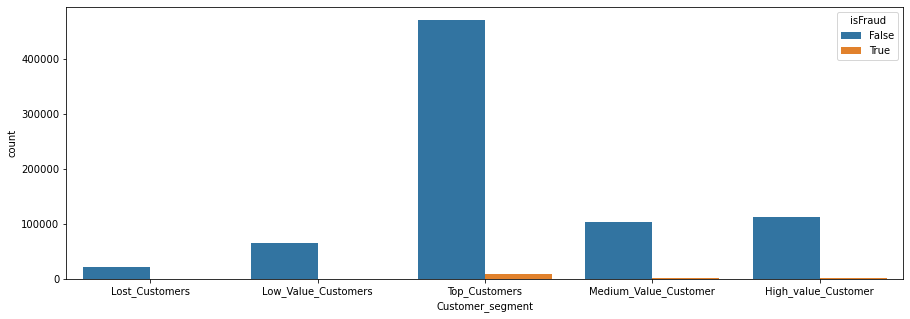

In [43]:
# Joining the rfm score and segmentation to the transaction data
tdata = tdata.merge(
    rfm_tdata[["customerId", "RFM_Score", "Customer_segment"]],
    on="customerId",
    how="left",
)

plt.figure(figsize=(15, 5))
sns.countplot(x="Customer_segment", hue="isFraud", data=tdata, orient="h")

##### Takeaway:

Visually top customers and high value tend to have more fradulent activity which can be the case becuase any hackers or fradulent person might target most active customers. This is just a business assumption.

In [44]:
# Lets quickly check if there is some relation b/w day of week and fradulent activity
tdata["trans_day_of_week"] = pd.to_datetime(tdata["transactionDate"]).dt.day_name()
tdata[tdata["isFraud"] == True]["trans_day_of_week"].value_counts()

Friday       1865
Monday       1802
Wednesday    1782
Thursday     1761
Tuesday      1760
Sunday       1728
Saturday     1719
Name: trans_day_of_week, dtype: int64

##### Looking at the split, we can quickly drop this feature as there is no relation on weekdays. And also fradulent activity by logic should not have a seasonality hence we can drop the date related columns.

In [45]:
tdata.drop(["trans_day_of_week"], axis=1, inplace=True)

One more hypothesis is that the different of accountopenDate and transaction date might be an important feature to test any fradulent activity

<AxesSubplot:xlabel='account_active_days'>

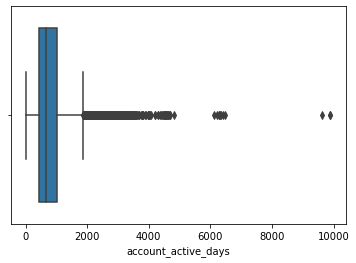

In [46]:
tdata["account_active_days"] = (
    pd.to_datetime(tdata["transactionDate"]) - pd.to_datetime(tdata["accountOpenDate"])
).dt.days

sns.boxplot(tdata[tdata["isFraud"] == True]["account_active_days"])

<AxesSubplot:xlabel='account_active_days'>

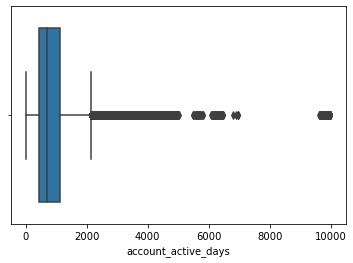

In [47]:
sns.boxplot(tdata[tdata["isFraud"] == False]["account_active_days"])

In [48]:
# No relation hence we can drop this feature
tdata.drop(["account_active_days"], axis=1, inplace=True)

In [49]:
# Saving the premodel data
tdata.to_csv(os.path.join(root_path, intermediate_folder,"premodel_data.csv"), index=False)

## Model Data Prep

Lets quickly look at the data that we have till now:

In [50]:
tdata.head(5)

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDate,transkey,transkeybdate,is_multiswipe,is_cvvmatch,addrs_chgcnt,RFM_Score,Customer_segment
0,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,UBER,US,US,02,01,RIDESHARE,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,2016-08-13,737265056_UBER_2016-08-13T14:27:32_98.55_PURCHASE,737265056_UBER_2016-08-13_98.55_PURCHASE,N,Y,1.0,0.20,Lost_Customers
1,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,ENTERTAINMENT,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,2016-10-11,737265056_AMC #191138_2016-10-11T05:05:54_74.5...,737265056_AMC #191138_2016-10-11_74.51_PURCHASE,N,Y,1.0,0.20,Lost_Customers
2,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,PLAY STORE,US,US,09,01,MOBILEAPPS,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,2016-11-08,737265056_PLAY STORE_2016-11-08T09:18:39_7.47_...,737265056_PLAY STORE_2016-11-08_7.47_PURCHASE,N,Y,1.0,0.20,Lost_Customers
3,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,PLAY STORE,US,US,09,01,MOBILEAPPS,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,2016-12-10,737265056_PLAY STORE_2016-12-10T02:14:50_7.47_...,737265056_PLAY STORE_2016-12-10_7.47_PURCHASE,N,Y,1.0,0.20,Lost_Customers
4,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,TIM HORTONS #947751,US,US,02,01,FASTFOOD,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,2016-03-24,830329091_TIM HORTONS #947751_2016-03-24T21:04...,830329091_TIM HORTONS #947751_2016-03-24_71.18...,N,Y,1.0,0.95,Lost_Customers


### Quick actions for model data prep:

1. Converting all the columns with boolean to 0,1 binary flags.
2. Dropping all the variables that are not required 
3. Imputing missing values. Categorical values are filled by most frequent values and numeric by mean - Taking quick call, need business approval though. As the missing percentage is low hence filling it.
2. Converting all the required categorical columns to dummy features

###### Lets create a copy before dropping any identity based columns

In [51]:
pre_mod_data = tdata.copy(deep=True)

In [52]:
# Step 1
print("Implementing Step 1: Converting all the columns with boolean to 0,1 binary flags")
bool_cols = ["cardPresent", "expirationDateKeyInMatch", "isFraud"]
for col in bool_cols:
    tdata[col] = tdata[col].replace({False: 0, True: 1})

yn_cols = ["is_multiswipe", "is_cvvmatch"]
for col in yn_cols:
    tdata[col] = tdata[col].replace({"N": 0, "Y": 1})
    
# Step 2 : Dropping cols
# Apart from dates cardCVV, enteredCVV,cardLast4Digits add no value in this fraud detection model
print("Implementing Step 2: Dropping all the variables that are not required")
drop_cols_mdl = [
    "transactionDateTime",
    "currentExpDate",
    "accountOpenDate",
    "dateOfLastAddressChange",
    "cardCVV",
    "enteredCVV",
    "cardLast4Digits",
    "transactionDate",
    "transkey",
    "transkeybdate",
    "merchantName",
    "customerId",
]
# Merchant name also dropped as we are considering the bucketed version of this variable i.e. merchant categories
tdata.drop(drop_cols_mdl, axis=1, inplace=True)

# Step 3: Missing value imputing
print("Implementing Step 3: Imputing missing values.")
tdata = DataFrameImputer().fit_transform(pd.DataFrame(tdata))
print("Total missing value count post imputation is ", tdata.isnull().sum().sum())

# Step 4: Dummy variable creation
print("Implementing Step 4: Dummy variale creation")
cat_cols = set(tdata.columns) - set(tdata._get_numeric_data().columns)

# Creating Dummy variables
tdata = onehotdataframe(data=tdata, cat_cols=cat_cols)

Implementing Step 1: Converting all the columns with boolean to 0,1 binary flags
Implementing Step 2: Dropping all the variables that are not required
Implementing Step 3: Imputing missing values.
Total missing value count post imputation is  0
Implementing Step 4: Dummy variale creation


#### Intuition for Under Sampling before Modelling

Note since our data is highly unbalanced, our model will tend to become biased towards the majority class as the majority class are non frauds and our objective is to accurately predict the fraud transactions it is very important to balance the data to maximum extent.

We will thus can use random undersampler to balance the data and reduce the chances of overfitting the data

Steps in random under sampling:

1. We should bring the non-fraud transactions to the same amount as fraud transactions or we can take 60/40 split we can test it though. For now lets take 50-50 split

2. After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data keeping the random state same to produce the same results everytime

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models might not be very accurate since there might be a lot of information loss and model can start predict more frauds to non fraud transactions which might be kept into the radar as that might be problem some for the company's genuine customers.

Lets split the data into train and test before implementing the undersampling 
technique as testing model over undersampled test set would induce overfit of data and data leakage issues.

As we dont have enough data points for fraud data lets consider 10% to avoid underfitting of data. As we will be having two level of model testing with validation and test set.
Also implementing stratified sampling to get the similar distribution of fraud and non fraud transaction in both test and train.

#### Implementing undersampling using Random Under Sampling:

In [53]:
# Splitting into test and train so that we can test the perfomance of modelling accurately
tdata_train, tdata_test = train_test_split(
    tdata, stratify=tdata["isFraud"], test_size=0.10, random_state=1000
)
# Note: I have kept a hold out test separate in above step with highly imbalance data to check the 
# model performance on actual input test data the model will be getting.

# Implementing undersampling
# Total fraud classes 12417 rows.
tdata_train = tdata_train.sample(frac=1, random_state=1000)
fraud_dt = tdata_train.loc[tdata["isFraud"] == 1]

# Taking 20% more non fraud data as this might reduce the risk of false fraud prediction by model and help the model with
# added information
non_fraud_dt = tdata_train.loc[tdata_train["isFraud"] == 0][
    : int(tdata_train["isFraud"].value_counts()[1] * 1.20)
]

# Getting the normally distributed sample
n_df = pd.concat([fraud_dt, non_fraud_dt])

# Shuffling the dataframe rows
tdata_trnusampled = n_df.sample(frac=1, random_state=1000)
tdata_trnusampled = tdata_trnusampled.reset_index(drop = True)

In [54]:
# Creating train, validation, test for model
X = tdata_trnusampled.drop(["isFraud"], axis=1).copy()
y = tdata_trnusampled["isFraud"].copy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.10, random_state=1000
)

# Taking from the previously seperated hold out test data
X_test = tdata_test.drop(["isFraud"], axis = 1)
y_test = tdata_test['isFraud']

print("Training data split \n")
print(y_train.value_counts())

print("\nValidation data split")
print(y_val.value_counts())

print("\Test data split")
print(y_test.value_counts())

Training data split 

0    12069
1    10057
Name: isFraud, dtype: int64

Validation data split
0    1341
1    1118
Name: isFraud, dtype: int64
\Test data split
0    77395
1     1242
Name: isFraud, dtype: int64


## Model selection intuition:

1. As there might be still noise in the data due to high sparsity, i am suspecting that logistic regression will under  perform with a lot of sparsty in the data.
2. Due to undersampling as stated earlier we might have some data loss. And as we have just 1 year of data for fraud detection, model might not gain good amount of information. Hence in the test set the models might underperform. Undersampling also associated a risk of reduction in precision of non-fraud class which might result in added flagging of actual non-fradulent transactions as fraud that might led to more trouble to the genuine company customers which could be troublesome. By continuous training the data lets say we keep adding the data for training of more years we can keep improving model performance.
3. In my assumption trees based model might perform better than linear as we can use bagging (in case of RF) to reduce variance in overfitting with a balanced trade off with biasness in check.
4. Boosting model like xgboost & lightgbm have high chances to overfit the data due to its small size which could restrict in making a generalized model.
5. First we can start with building vanilla models then select the best model which generalizes the data well when tested over the hold out test that we kept for 2 layered testing.

Models which can try to build are Logistic Regression, SVM, Random Forest, XGBoost and LightGBM

In [55]:
class VanillaModelpipeline(object):
    
    """
        Creates a modelling pipline for Logistic Regression, SVM, Random Forest, Xgboost, LGBM

        Input:
        X_train = Train data
        y_train = Train data true values
        X_val = Validation Set
        y_val = Validation set true values
        X_test = Test Set
        y_test = Test set true values
        std_scal_req = Standard scaling required or not

        Output:
        Individual functions return respective fitted model.
        Compare model function returns the performance over roc_auc_curve to give a rough fit idea
   """
    def __init__(
        self,
        X_train=None,
        y_train=None,
        X_val=None,
        y_val=None,
        X_test=None,
        y_test=None,
        std_scal_req=True,
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.std_scal_req = std_scal_req

    def LR(self):
        print("Fitting Vanilla Logistic Regression Model")
        # LR requires feature scaling.
        if self.std_scal_req:
            self.lrmodel = make_pipeline(StandardScaler(), LogisticRegression())
            self.lrmodel.fit(X_train, y_train)
            print("Vanilla Logistic Regression Model Fitted...OK\n")
        else:
            self.lrmodel = LogisticRegression()
            self.lrmodel.fit(X_train, y_train)
        return self.lrmodel

    def RF(self):
        print("Fitting Vanilla Random Forest Model")
        self.rfmodel = RandomForestClassifier()
        self.rfmodel.fit(X_train, y_train)
        print("Vanilla Random Forest Model Fitted..OK\n")
        return self.rfmodel

    def SVM(self):
        # SVM requires feature scaling
        print("Fitting SVM Model")
        if self.std_scal_req:
            self.svmModel = make_pipeline(StandardScaler(), SVC())
            self.svmModel.fit(X_train, y_train)
            print("Vanilla SVM Model Fitted...OK\n")
        else:
            self.svmModel = SVC()
            self.svmModel.fit(X_train, y_train)
        return self.svmModel

    def XGB(self):
        print("Fitting XGB Model")
        self.xgbModel = XGBClassifier()
        self.xgbModel.fit(X_train, y_train)
        print("XGB Model Fitted...OK\n")
        return self.xgbModel

    def LGBM(self):
        print("Fitting LGBM Model")
        self.lgbmModel = LGBMClassifier()
        self.lgbmModel.fit(X_train, y_train)
        print("LGBM Model Fitted...OK\n")
        return self.lgbmModel

    def compare_models(self):

        # LR Pred
        print("Starting Modelling Pipeline \n")
        lr_model = self.LR()
        lr_pred_val = [y_val, lr_model.predict(X_val)]

        # SVM Pred
        svm_model = self.SVM()
        svm_pred_val = [y_val, svm_model.predict(X_val)]

        # RF Pred
        rf_model = self.RF()
        rf_pred_val = [y_val, rf_model.predict(X_val)]

        # XGB Pred
        xgb_model = self.XGB()
        xgb_pred_val = [y_val, xgb_model.predict(X_val)]

        # LGBM Pred
        lgbm_model = self.LGBM()
        lgbm_pred_val = [y_val, lgbm_model.predict(X_val)]

        model_pred_dict_val = {
            "Logistic Regression": lr_pred_val,
            "SVM": svm_pred_val,
            "Random Forest": rf_pred_val,
            "XGBoost": xgb_pred_val,
            "Light GBM": lgbm_pred_val,
        }

        plt.figure(figsize=(10, 10))
        for key, value in model_pred_dict_val.items():
            fpr, tpr, _ = roc_curve(value[0], value[1])
            sns.lineplot(x=fpr, y=tpr, label=key)
        ax = sns.lineplot(x=[0, 0.5, 1], y=[0, 0.5, 1])
        ax.lines[len(model_pred_dict_val)].set_linestyle("--")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC Curve")

In [56]:
model_class = VanillaModelpipeline(X_train, y_train, X_val, y_val, X_test, y_test, True)

Starting Modelling Pipeline 

Fitting Vanilla Logistic Regression Model
Vanilla Logistic Regression Model Fitted...OK

Fitting SVM Model
Vanilla SVM Model Fitted...OK

Fitting Vanilla Random Forest Model
Vanilla Random Forest Model Fitted..OK

Fitting XGB Model
[13:26:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Model Fitted...OK

Fitting LGBM Model
LGBM Model Fitted...OK



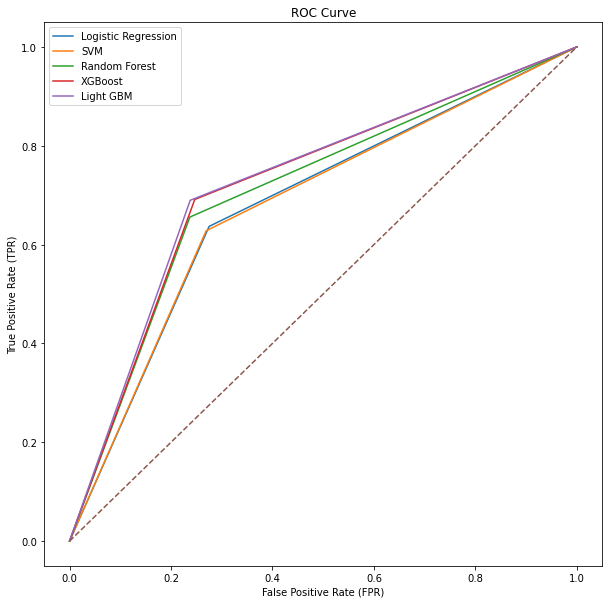

In [57]:
model_class.compare_models()

### Logistic Regression Deepdive

Fitting Vanilla Logistic Regression Model
Vanilla Logistic Regression Model Fitted...OK

Classification Report for LR model on validation set

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1341
           1       0.66      0.64      0.65      1118

    accuracy                           0.68      2459
   macro avg       0.68      0.68      0.68      2459
weighted avg       0.68      0.68      0.68      2459


 accuracy: 0.6848312322082147 & roc_auc_score: 0.6808418676687757 

Classification Report for LR model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.72      0.84     77395
           1       0.04      0.64      0.07      1242

    accuracy                           0.72     78637
   macro avg       0.51      0.68      0.45     78637
weighted avg       0.98      0.72      0.82     78637


 accuracy: 0.7211617940664063 & roc_auc_score: 0.6832602354922919 

Confusio

(array([[972, 369],
        [406, 712]]),
 array([[55910, 21485],
        [  442,   800]]))

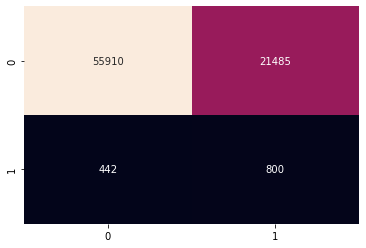

In [58]:
# Logistic Regression Deepdive
lr_model = model_class.LR()
gen_class_report(lr_model, "LR", X_val, y_val, X_test, y_test, False)

### SVM Deep Dive

Fitting SVM Model
Vanilla SVM Model Fitted...OK

Classification Report for SVM model on validation set

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1341
           1       0.66      0.63      0.64      1118

    accuracy                           0.68      2459
   macro avg       0.68      0.68      0.68      2459
weighted avg       0.68      0.68      0.68      2459


 accuracy: 0.684017893452623 & roc_auc_score: 0.6793524443750759 

Classification Report for SVM model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.72      0.84     77395
           1       0.04      0.63      0.07      1242

    accuracy                           0.72     78637
   macro avg       0.51      0.68      0.45     78637
weighted avg       0.98      0.72      0.82     78637


 accuracy: 0.7204496611010084 & roc_auc_score: 0.6761644809096196 

Confusion matrix on test set : 



(array([[980, 361],
        [416, 702]]),
 array([[55871, 21524],
        [  459,   783]]))

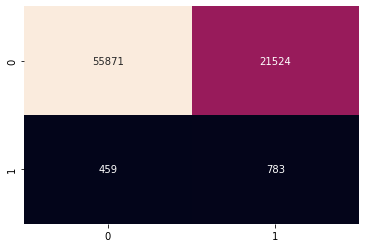

In [59]:
svm_model = model_class.SVM()
gen_class_report(svm_model, "SVM", X_val, y_val, X_test, y_test, False)

### Random Forest Deep Dive

Fitting Vanilla Random Forest Model
Vanilla Random Forest Model Fitted..OK

Classification Report for RF model on validation set

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1341
           1       0.70      0.67      0.68      1118

    accuracy                           0.72      2459
   macro avg       0.72      0.71      0.71      2459
weighted avg       0.72      0.72      0.72      2459


 accuracy: 0.7173647824318828 & roc_auc_score: 0.7131989717443128 

Classification Report for RF model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.75      0.86     77395
           1       0.04      0.69      0.08      1242

    accuracy                           0.75     78637
   macro avg       0.52      0.72      0.47     78637
weighted avg       0.98      0.75      0.85     78637


 accuracy: 0.753729160573267 & roc_auc_score: 0.7200071542567827 

Confusion matrix on te

'\nNote this the base model --- \nWe will refer this model with future models when I tune  something & observe improvement in performance.\n'

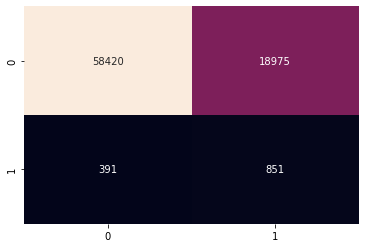

In [60]:
rf_model = model_class.RF()
gen_class_report(rf_model, "RF", X_val, y_val, X_test, y_test, False)

"""
Note this the base model --- 
We will refer this model with future models when I tune  something & observe improvement in performance.
"""

### XGBoost Deep Dive

Fitting XGB Model
[13:30:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Model Fitted...OK

Classification Report for XGBoost model on validation set

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1341
           1       0.70      0.69      0.70      1118

    accuracy                           0.73      2459
   macro avg       0.72      0.72      0.72      2459
weighted avg       0.72      0.73      0.72      2459


 accuracy: 0.725091500610004 & roc_auc_score: 0.7222912572920377 

Classification Report for XGBoost model on hold out test set

              precision    recall  f1-score   support

           0       0.99     

(array([[1010,  331],
        [ 345,  773]]),
 array([[57951, 19444],
        [  372,   870]]))

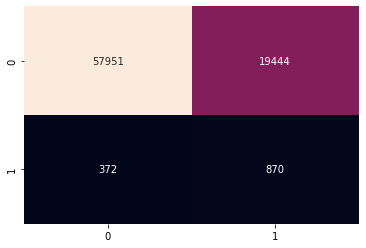

In [61]:
xgb_model = model_class.XGB()
gen_class_report(xgb_model, "XGBoost", X_val, y_val, X_test, y_test, False)

### LGBM model deep dive

Fitting LGBM Model
LGBM Model Fitted...OK

Classification Report for LightGBM model on validation set

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1341
           1       0.71      0.69      0.70      1118

    accuracy                           0.73      2459
   macro avg       0.73      0.73      0.73      2459
weighted avg       0.73      0.73      0.73      2459


 accuracy: 0.7291581943879626 & roc_auc_score: 0.72587107583986 

Classification Report for LightGBM model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     77395
           1       0.04      0.69      0.08      1242

    accuracy                           0.76     78637
   macro avg       0.52      0.73      0.47     78637
weighted avg       0.98      0.76      0.85     78637


 accuracy: 0.7555603596271475 & roc_auc_score: 0.7252947242739864 

Confusion matrix on test set : 



(array([[1022,  319],
        [ 347,  771]]),
 array([[58553, 18842],
        [  380,   862]]))

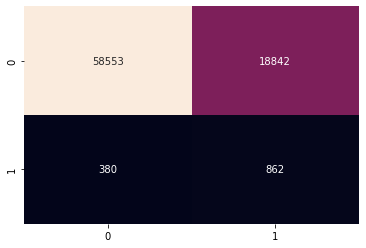

In [62]:
lgbm_model = model_class.LGBM()
gen_class_report(lgbm_model, "LightGBM", X_val, y_val, X_test, y_test, False)

### Vanilla Model result analysis:

Metric in check f1_macro and weighted avg : As the class is highly imbalanced in the real world:

1) As expected logistic regression & SVM were worst performing model due to the high dimensionality of the data as  well some effect of outliers which are difficult to be removed without business inputs. If we look at ROC_AUC curve then too its evident that these model doesnt fit the data better than the other models.

2) Random Forest, XGB an LGBM perform almost similar. If we even compare the accuracy RF~LGM > XGB. Also I am more inclined towards using random forest as bagging algorithms are less prone to overfitting in future unseen datasets if the boosting models are trained over small training data. Hence selecting RF as the champion model.

3) Also as expected out model precision losses over the hold out test set in all the models. Potentially as I mentioned earlier there are two major reasons first due to undersampling there is information loss second we just have 1 year of data to train with just 2% of overall data is the fraud class.

### Next steps:
1) Lets plot the feature importance plot and see what features we can remove to remove noise from data.

2) Lets combine the train and validation set and perform a quick hyperparameter tuning.

3) Return RF as final model

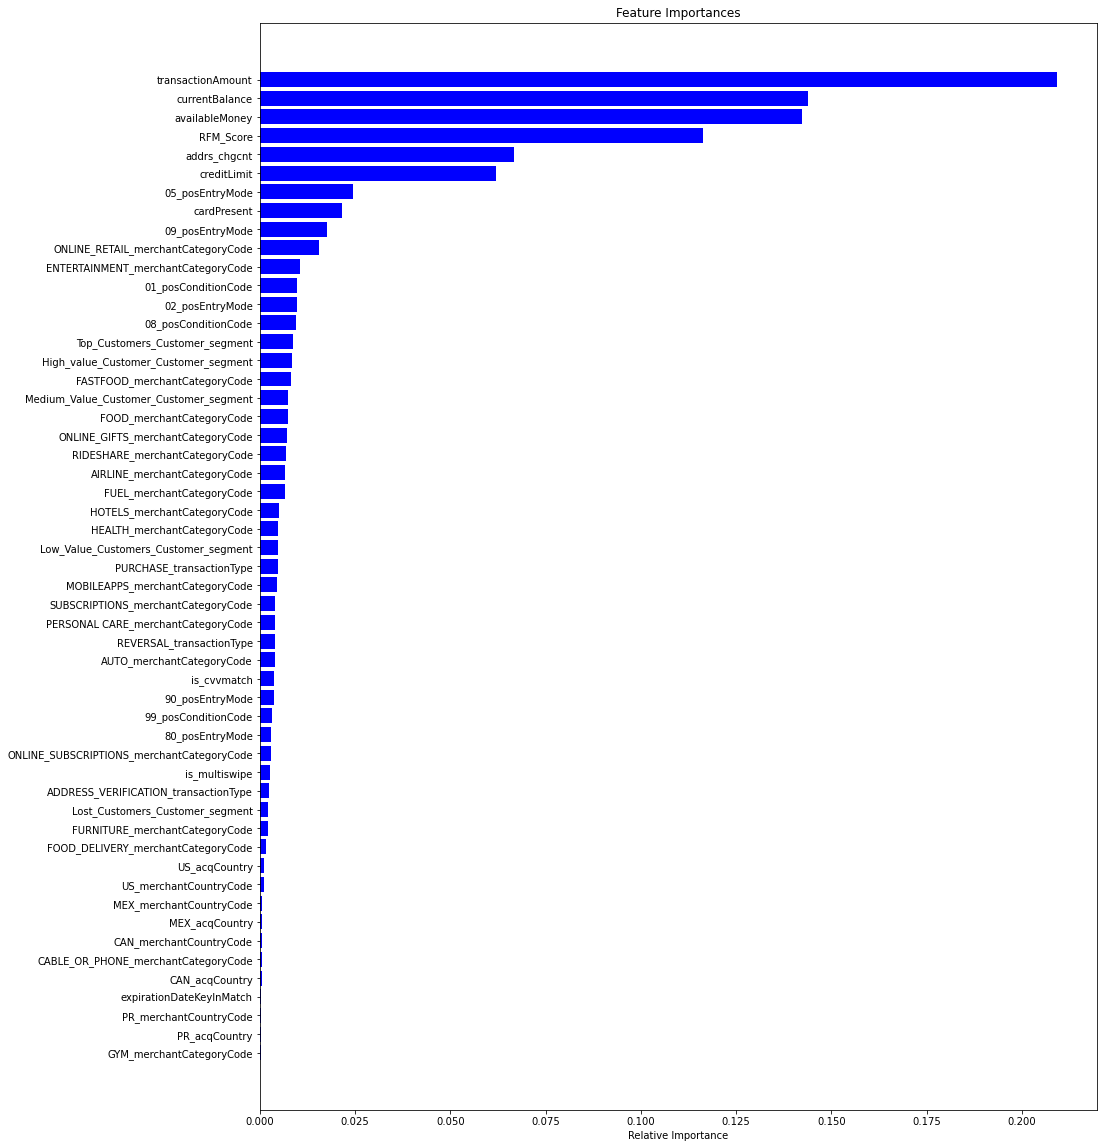

In [63]:
indices, importances = get_feat_imp_plot(rf_model,X)

##### Takeaways:

1. Tree based models are prone to be biased towards highly cardinal features hence we cannot directly remove some features. However bottom 10 features can be removed as the relative importance is neglible.
2. We can implement feature selection & recursive feature elimination combo to select the best features for out model and check if the technique work and we observe any improvement in our results.

F1_Score_Avg: 0.644 (0.010)
Classification Report for RF model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     77395
           1       0.04      0.66      0.07      1242

    accuracy                           0.73     78637
   macro avg       0.52      0.70      0.46     78637
weighted avg       0.98      0.73      0.83     78637


 accuracy: 0.7339674707834735 & roc_auc_score: 0.6964997978144822 

Confusion matrix on test set : 



('',
 array([[56900, 20495],
        [  425,   817]]))

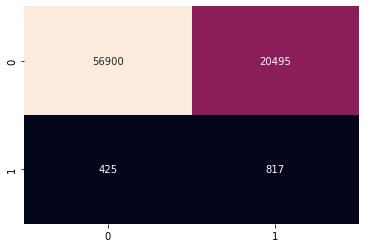

In [64]:
# Testing recursive elimination using random forest
# This code takes some 5 mins to run as CV is running and recursively model trains with shuffling

# First implement feature selection using random forest
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)
selected_feat = X_train.columns[(sel.get_support())]
len(selected_feat)

# Then implementing random feature elimination to select best features
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=len(selected_feat))
model = RandomForestClassifier()
pipeline = Pipeline(steps=[("s", rfe), ("m", model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(
    pipeline, X, y, scoring="f1", cv=cv, n_jobs=-1, error_score="raise"
)
# report performance
print("F1_Score_Avg: %.3f (%.3f)" % (np.mean(n_scores), np.std(n_scores)))

# Fitting the model and checking we could improve the results
pipeline.fit(X, y)
gen_class_report(pipeline, "RF", None, None, X_test, y_test, True)

##### Note: Ensemble of feature selection & feature elimination didnt work out. The f1-score for fraud class dropped hence we will not be using this method in our analysis

### Worst Feature Elimination & Performance check

Classification Report for RF model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     77395
           1       0.04      0.68      0.08      1242

    accuracy                           0.75     78637
   macro avg       0.52      0.72      0.47     78637
weighted avg       0.98      0.75      0.85     78637


 accuracy: 0.7549245266223279 & roc_auc_score: 0.717841615761378 

Confusion matrix on test set : 



('',
 array([[58521, 18874],
        [  398,   844]]))

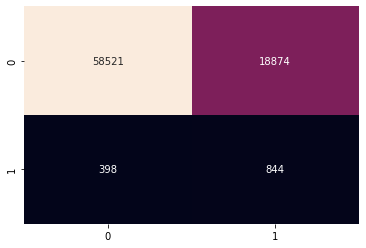

In [65]:
# Before we tune the model lets remove the bottom 10 worst predictor to remove noise to some extent
features = list(X.columns)
final_feature_set = [features[i] for i in indices][9:]

# Fitting the model and checking we could improve the results
rf_model = RandomForestClassifier()
rf_model.fit(X[final_feature_set], y)
gen_class_report(rf_model, "RF", None, None, X_test[final_feature_set], y_test, True)

##### Takeaway
Voila we observed 1% improvement in both recall for predicting 1s and 1% improvement in ROC_AUC value

## Model tuning - Using Hyperopt

### Implementing Hyperopt

In [66]:
# Defining the space - Keeping the hyperparamter range such that we build a generalized model
space = {
    "n_estimators": hp.randint("n_estimators", 200, 1000),
    "max_depth": hp.randint("max_depth", 3, 30),
}
trials = Trials()

# Defining the hyperopt loss function
def hyperparameter_tuning(params):
    params["max_depth"] = int(params["max_depth"])
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state = 1000)
    # acc = CVScores(clf, cv=5, scoring='f1_weighted')
    acc = cross_val_score(clf, X[final_feature_set], y, scoring="f1_weighted").mean()
    return {"loss": -acc, "status": STATUS_OK}

best = fmin(
    fn=hyperparameter_tuning, space=space, algo=tpe.suggest, max_evals=30, trials=trials
)

print("Best: {}".format(best))

# Getting best parameters
best_params = space_eval(space, best)
best_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state = 1000)

# from auc_roc --
best_model.fit(X[final_feature_set], y)

100%|██████████| 30/30 [03:55<00:00,  7.84s/trial, best loss: -0.71934073571254]
Best: {'max_depth': 21, 'n_estimators': 911}


RandomForestClassifier(max_depth=21, n_estimators=911, n_jobs=-1,
                       random_state=1000)

Classification Report for RF model on hold out test set

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     77395
           1       0.04      0.70      0.08      1242

    accuracy                           0.76     78637
   macro avg       0.52      0.73      0.47     78637
weighted avg       0.98      0.76      0.85     78637


 accuracy: 0.7601383572618488 & roc_auc_score: 0.7284126881581497 

Confusion matrix on test set : 



('',
 array([[58911, 18484],
        [  378,   864]]))

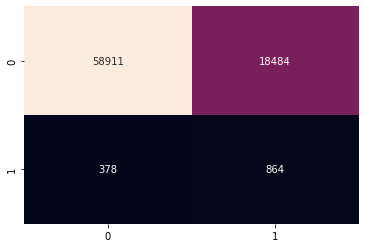

In [67]:
gen_class_report(best_model, "RF", None, None, X_test[final_feature_set], y_test, True)

##### Takeaways:

We have now got our best performing tuned model random forest model. We can see that we were further able to improve the precision of class 1 by 1% as well as we were able to improve the roc_auc_score as well.

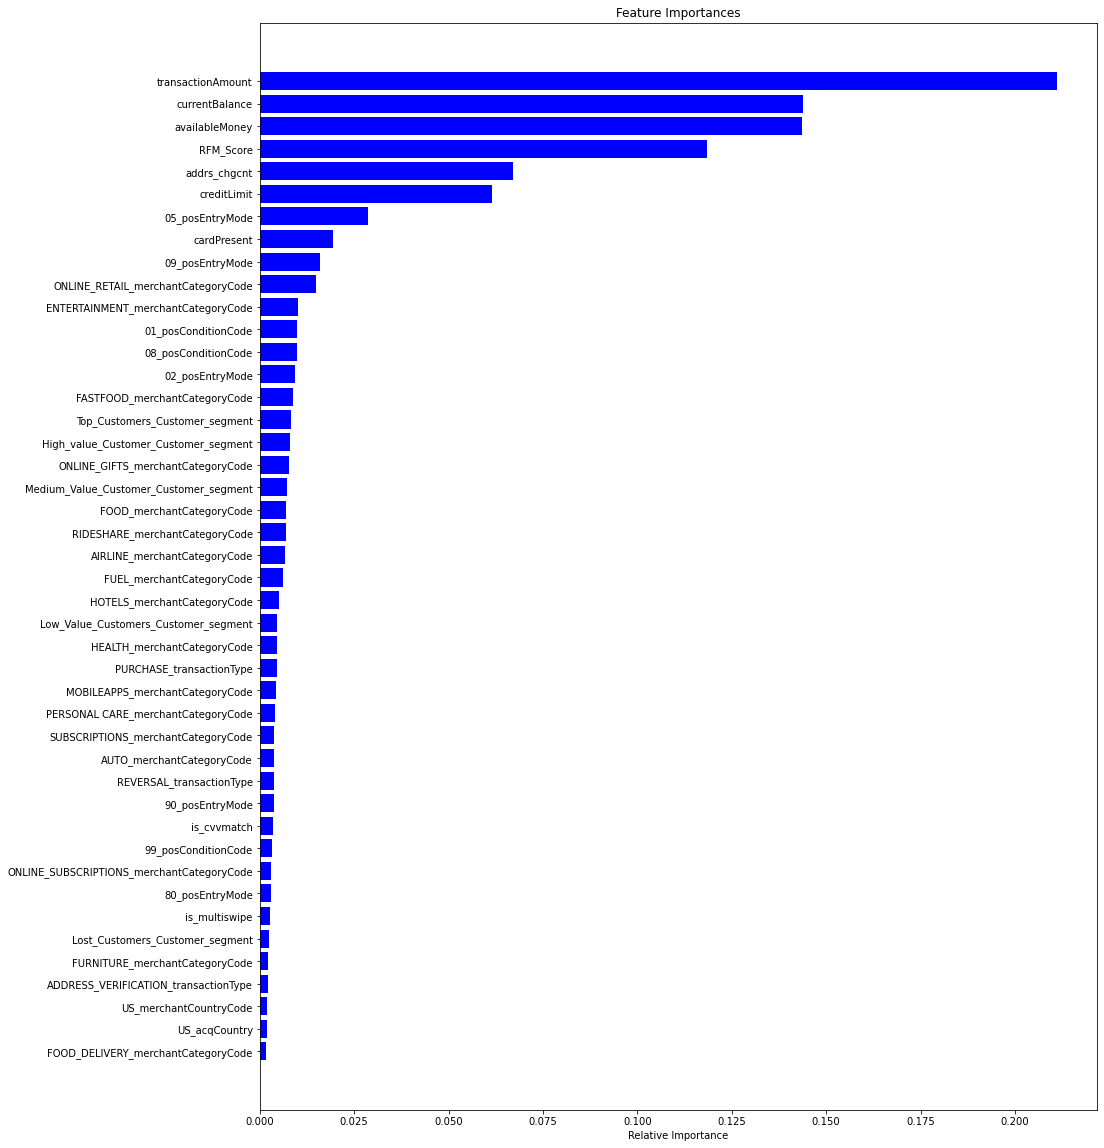

(array([ 2,  1,  0,  5,  3,  4,  6,  8,  7,  9, 11, 10, 13, 12, 15, 14, 16,
        17, 19, 18, 20, 21, 22, 23, 25, 26, 24, 28, 29, 27, 31, 30, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([0.00188113, 0.00182776, 0.00151426, 0.00206123, 0.00230439,
        0.00205063, 0.00271011, 0.0029948 , 0.00290268, 0.00312842,
        0.00370703, 0.00355832, 0.00381786, 0.00378257, 0.00409343,
        0.003822  , 0.00437053, 0.00449597, 0.00465531, 0.00459048,
        0.00510629, 0.00620278, 0.00660104, 0.00695904, 0.00782306,
        0.00703764, 0.0071943 , 0.00887969, 0.00811541, 0.00836222,
        0.00991887, 0.00934746, 0.00995086, 0.01001594, 0.01482634,
        0.01586185, 0.01937785, 0.02871745, 0.06156549, 0.06694017,
        0.11833633, 0.14361911, 0.14383447, 0.21113743]))

In [68]:
get_feat_imp_plot(best_model, X[final_feature_set])

### Key features for the model

1. Although RF model is biased towards highly cardinal features, we can still derive insights from the plot. Transaction Amount, current Balance, RFM Score, add_chngcnt, creditlimit are top features as expected. People with high balance, bigger transactions amounts, more frequent address changes (add_chngcnt), and people people with high credit limit are more prone to fraud.

2. Some of the feature that we expected might be an important predicter like is_multiswipe, is_cvvmatch come below the importance list. Maybe the model was not able to homogenity in its child nodes.

3. All the different category codes flags especially online_retail and online_gift card came up in the charts as expected which might be proven to be important predictors for class 1 as we hypothesized during EDA.

4. Also roughly 23% of the prediction are fraud false which is a significantly high number. Machine learning models are not fully accurate given the complexity of data it is trained on. Hence we can further club some business rules to identify false predicted fraud detection so that genuine customers are not troubled. Some idea might be to check the historic trend count of duplicates for that customer. I thought this feature might be a leaky feature and might induce biasness hence i didnt added this but we can club results with business feedbacks.

### Final Ending note:
    
1) I have performed all these in interest of the time as much as I can. ML models require business inputs and added features which can help support the minority class.

2) Most of the features already I tried to cover as well (about their potential impace & relation with target class)

3) If we have more time we could reseaerch more about more efficient undersampling technique which could prevent infomation loss to maximum extent. Like I am still in process to read about genetic algorithms and other techniques for the same. In addition due to some version issue I could not implement SMOTE.

4) And again I have created a RF model, bagging model are pretty stable in terms of their performance over unseen data. If we would want the model to improve with time we can keep injesting more and more data so that the model can capture more nuisances of fraudulent cases.

5) Due to lack of time I could not write a fully modular code, however if this a full fledge project we can write a full modular pipelined code with removal of all sort of hard coding and adding exception handling and log files. We can use Azure/AWS MLOps lifecycle to add model monitoring, data drift, timely data refreshes/model refreshes and all other dependencies.

6) What I tried and what failed - So I created some extra feature to check if those make sense and add value but they weren't altough some features like RFM score & address change counts did came up in the feature importance plot and might have added value. Lastly there was some versioning issue I was facing due to which I couldn'd implement SMOTE and other downsamplng technique which might have helped. Also I tried feature selection + recurrsive feature elimination technique for improving model performance which also didnt work out.

### Few questions I had:
1) What does feature like pos_conditioncode, posEntryMode mean?

2) Can we have more data?

3) I was surprised to see a lot of address change more than 50 of a customer in an year as well and few cases there were no fraud cases? Is the data correct?

4) How can fraud activities happen on websites like walmart and in apps like uber in which the money will go towards company's banking rather than an individual? I need to understand how fraudsters get benefit from this.

#### I hope I was clear in my approach and understanding

THE END